# Business Understanding

Pneumonia remains a leading cause of death in developing countries and also among the very old, young, and chronically ill. Since access to proper healthcare and doctors is limited in developing countries, it is vital that a predictive model be able to diagnose chest x-rays to determine whether a patient has pneumonia in order to begin treatment right away. 

# Data Understanding

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

# EDA and Data Preprocessing

In [106]:
# importing libraries 
import os, shutil
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.dummy import DummyClassifier
from sklearn.metrics import  classification_report, log_loss, accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay 

from keras import models, layers, optimizers, regularizers
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

tf.random.set_seed(9)
np.random.seed(9)

In [2]:
# loading datasets
data_train_normal = 'input/chest_xray/train/NORMAL'
data_train_pneumonia = 'input/chest_xray/train/PNEUMONIA'
data_val_normal = 'input/chest_xray/val/NORMAL'
data_val_pneumonia = 'input/chest_xray/val/PNEUMONIA'
data_test_normal = 'input/chest_xray/test/NORMAL'
data_test_pneumonia = 'input/chest_xray/test/PNEUMONIA'

train_data = 'input/chest_xray/train'
val_data = 'input/chest_xray/val'
test_data = 'input/chest_xray/test'

In [3]:
# function for plotting model performance
def visualize_training_results(histories):
    history = histories.history  
    
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.title("Training vs validation loss")
    
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,2)
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title("Training vs validation accuracy")
    plt.show();

In [4]:
# function for classification report and confusion matrix
def reports(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred.round()))
    fig, ax = plt.subplots(figsize=(4,4))
    cm = confusion_matrix(y, np.round(pred), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.asarray(['Normal','Pneumonia']))
    fig = disp.plot(cmap='Blues', ax=ax)
    plt.show();

In [5]:
print('There are', len(os.listdir(data_train_normal)), 'NORMAL images in the train set')
print('There are', len(os.listdir(data_train_pneumonia)), 'Pneumonia images in the train set')
print('There are', len(os.listdir(data_val_normal)), 'NORMAL images in the validation set')
print('There are', len(os.listdir(data_val_pneumonia)), 'Pneumonia images in the validation set')
print('There are', len(os.listdir(data_test_normal)), 'NORMAL images in the test set')
print('There are', len(os.listdir(data_test_pneumonia)), 'Pneumonia images in the test set')

There are 1341 NORMAL images in the train set
There are 3875 Pneumonia images in the train set
There are 8 NORMAL images in the validation set
There are 8 Pneumonia images in the validation set
There are 234 NORMAL images in the test set
There are 390 Pneumonia images in the test set


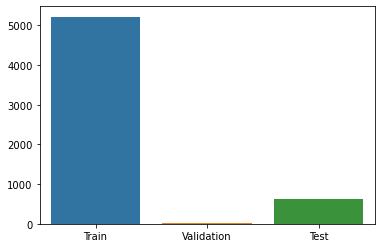

In [6]:
# plotting dataset size
sns.barplot(x=["Train","Validation","Test"],
            y=[len(os.listdir(data_train_normal))+len(os.listdir(data_train_pneumonia)), 
               len(os.listdir(data_val_normal))+len(os.listdir(data_val_pneumonia)),
               len(os.listdir(data_test_normal))+len(os.listdir(data_test_pneumonia))]);

>The split among the train, validation, test datasets does not look reasonably balanced so it will be re-distributed to a 60:20:20 split respectively. To do so, we will create new directories, one for all pneumonia chest images and the other for all normal chest images, then aggregate the images accordingly. Next, we will create new train, validatio, test folders and re-distribute the images into these folders. 

## Train-Validation-Test Resplit

In [7]:
# directory variables
norm_dir = 'input/normal'
pne_dir = 'input/pneumonia'
new_dir = 'split/'

In [8]:
# aggregating images
norm_imgs = [file for file in os.listdir(norm_dir) if file.endswith('.jpeg')]
pne_imgs = [file for file in os.listdir(pne_dir) if file.endswith('.jpeg')]

In [9]:
print('There are', len(norm_imgs), 'normal images.')
print('There are', len(pne_imgs), 'pneumonia images.')

There are 1583 normal images.
There are 4273 pneumonia images.


The following steps need to be completed only once so they are commented out.

In [10]:
# # creating new directories
# os.mkdir(new_dir)

In [11]:
train_folder = os.path.join(new_dir, 'train')
train_norm = os.path.join(train_folder, 'norm')
train_pne = os.path.join(train_folder, 'pne')

val_folder = os.path.join(new_dir, 'validation')
val_norm = os.path.join(val_folder, 'norm')
val_pne = os.path.join(val_folder, 'pne')

test_folder = os.path.join(new_dir, 'test')
test_norm = os.path.join(test_folder, 'norm')
test_pne = os.path.join(test_folder, 'pne')

In [12]:
# os.mkdir(train_folder)
# os.mkdir(train_norm)
# os.mkdir(train_pne)

# os.mkdir(val_folder)
# os.mkdir(val_norm)
# os.mkdir(val_pne)

# os.mkdir(test_folder)
# os.mkdir(test_norm)
# os.mkdir(test_pne)

In [13]:
# determining split - normal
(len(norm_imgs)*60)/100, (len(norm_imgs)*20)/100

(949.8, 316.6)

In [14]:
# # train normal
# imgs = norm_imgs[:950]
# for img in imgs:
#     origin = os.path.join(norm_dir, img)
#     destination = os.path.join(train_norm, img)
#     shutil.copyfile(origin, destination)

# # validation normal
# imgs = norm_imgs[950:1266]
# for img in imgs:
#     origin = os.path.join(norm_dir, img)
#     destination = os.path.join(val_norm, img)
#     shutil.copyfile(origin, destination)

# # test normal
# imgs = norm_imgs[1266:]
# for img in imgs:
#     origin = os.path.join(norm_dir, img)
#     destination = os.path.join(test_norm, img)
#     shutil.copyfile(origin, destination)

In [15]:
# determining split - pnemonia
(len(pne_imgs)*60)/100, (len(pne_imgs)*20)/100

(2563.8, 854.6)

In [16]:
# # train pneumonia
# imgs = pne_imgs[:2564]
# for img in imgs:
#     origin = os.path.join(pne_dir, img)
#     destination = os.path.join(train_pne, img)
#     shutil.copyfile(origin, destination)

# # validation pneumonia
# imgs = pne_imgs[2564:3419]
# for img in imgs:
#     origin = os.path.join(pne_dir, img)
#     destination = os.path.join(val_pne, img)
#     shutil.copyfile(origin, destination)

# # test pneumonia
# imgs = pne_imgs[3419:]
# for img in imgs:
#     origin = os.path.join(pne_dir, img)
#     destination = os.path.join(test_pne, img)
#     shutil.copyfile(origin, destination)

In [17]:
print('There are', len(os.listdir(train_norm)), 'NORMAL images and ',
      len(os.listdir(train_pne)), 'Pneumonia images in the train set.')
print('There are', len(os.listdir(val_norm)), 'NORMAL images and ',
      len(os.listdir(val_pne)), 'Pneumonia images in the validation set.')
print('There are', len(os.listdir(test_norm)), 'NORMAL images and ', 
      len(os.listdir(test_pne)), 'Pneumonia images in the test set.')

print('There are', len(os.listdir(train_norm))+len(os.listdir(train_pne)), 'images in the train set.')
print('There are', len(os.listdir(val_norm))+len(os.listdir(val_pne)), 'images in the validation set')
print('There are', len(os.listdir(test_norm))+len(os.listdir(test_pne)), 'images in the test set.')

There are 950 NORMAL images and  2564 Pneumonia images in the train set.
There are 316 NORMAL images and  855 Pneumonia images in the validation set.
There are 317 NORMAL images and  854 Pneumonia images in the test set.
There are 3514 images in the train set.
There are 1171 images in the validation set
There are 1171 images in the test set.


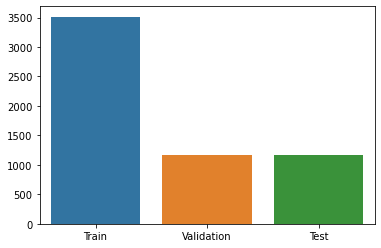

In [18]:
# plotting re-distributed dataset
sns.barplot(x=["Train","Validation","Test"],
            y=[len(os.listdir(train_norm))+len(os.listdir(train_pne)),
               len(os.listdir(val_norm))+len(os.listdir(val_pne)),
               len(os.listdir(test_norm))+len(os.listdir(test_pne))]);

> Now, our re-splited dataset looks more reasonably distributed.

## Class Imbalance

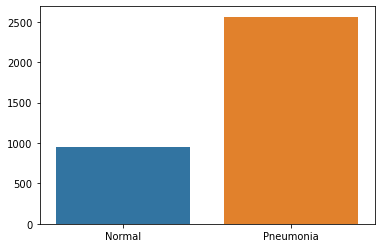

In [19]:
# plotting distribution of target variable
sns.barplot(x=["Normal","Pneumonia"],
            y=[len(os.listdir(train_norm)),len(os.listdir(train_pne))]);

>We also see that there is class imbalance. To mitigate this issue, we will try data augmentation and class weight method. Data augmentation is done with image data generator. During this step, we will rescale the images by dividing the pixel values by 255. We will also configure the images to shape (220, 220) to maintain uniform size of the image.

In [20]:
# creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.3,
                                   zoom_range=0.1,
                                   horizontal_flip=False)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_folder, batch_size=3514, class_mode='binary', target_size=(220, 220))
val_generator = val_datagen.flow_from_directory(val_folder, batch_size=1171, class_mode = 'binary', target_size=(220, 220))
test_generator = test_datagen.flow_from_directory(test_folder, batch_size=1171, shuffle=False, class_mode = 'binary', target_size=(220, 220))

Found 3514 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.


In [21]:
# images and their labels
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [22]:
# exploring datasets
m_train = train_images.shape[0]
m_val = val_images.shape[0]
m_test = test_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of validation samples: " + str(m_val))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 3514
Number of validation samples: 1171
Number of testing samples: 1171
train_images shape: (3514, 220, 220, 3)
train_labels shape: (3514,)
val_images shape: (1171, 220, 220, 3)
val_labels shape: (1171,)
test_images shape: (1171, 220, 220, 3)
test_labels shape: (1171,)


In [23]:
# binary class
train_labels

array([1., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [24]:
# reshaping 
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

print("train_img shape: ", train_img.shape)
print("val_img shape: ", val_img.shape)
print("test_img shape: ", test_img.shape)

train_img shape:  (3514, 145200)
val_img shape:  (1171, 145200)
test_img shape:  (1171, 145200)


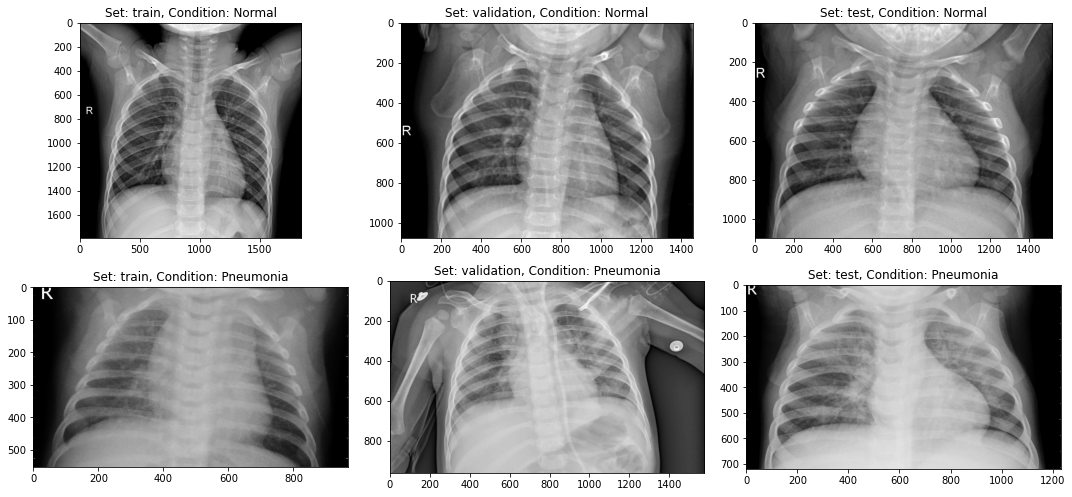

In [26]:
# plotting x-ray images
input_path = 'split/'
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['train', 'validation', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/norm/'+os.listdir(set_path+'/norm')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/pne/'+os.listdir(set_path+'/pne')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

# Model Building

Now, we will build some image classification models. We will start with a dummy classifier as our baseline model and then build a simple neural network model. 

We will also utilize EarlyStopping not only to save time and computational power but also to prevent overfitting and underfitting as this will stop training when the model performance stops improving on a validation dataset. 

## Baseline Model - Dummy Classifier

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       950
         1.0       0.73      1.00      0.84      2564

    accuracy                           0.73      3514
   macro avg       0.36      0.50      0.42      3514
weighted avg       0.53      0.73      0.62      3514



/home/cryoetsoft/anaconda3/envs/jupytergpu/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cryoetsoft/anaconda3/envs/jupytergpu/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cryoetsoft/anaconda3/envs/jupytergpu/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

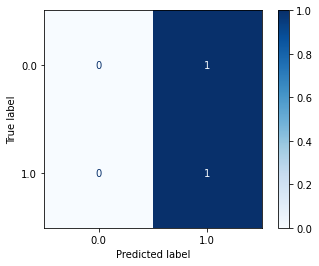

In [27]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(train_img, train_labels)

dummy_y_pred = dummy_clf.predict(train_img)
print(classification_report(train_labels, dummy_y_pred))
plot_confusion_matrix(dummy_clf, train_img, train_labels, normalize='true', cmap='Blues')

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       317
         1.0       0.73      1.00      0.84       854

    accuracy                           0.73      1171
   macro avg       0.36      0.50      0.42      1171
weighted avg       0.53      0.73      0.62      1171



/home/cryoetsoft/anaconda3/envs/jupytergpu/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cryoetsoft/anaconda3/envs/jupytergpu/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cryoetsoft/anaconda3/envs/jupytergpu/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

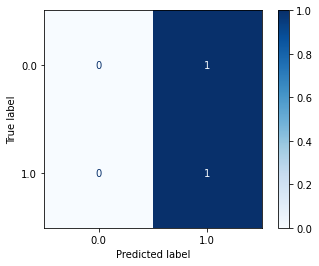

In [28]:
dummy_y_pred = dummy_clf.predict(test_img)
print(classification_report(test_labels, dummy_y_pred))
plot_confusion_matrix(dummy_clf, test_img, test_labels, normalize='true', cmap='Blues')

The model has an accuracy score of 73% and shows the class imbalance issue. This dummy classifier will be our baseline to determine how our other models perform in predicting whether an x-ray image has pnuemonia or not. The recall score will also be evaluated for each model to ensure that it is correctly identifying which patients has pneumonia. 

A high recall score lowers the chances of false negatives (x-ray image is negative when it is actually positive), but increases the chance of false positives (the x-ray image is postive when it is actually negative). 

## First Model 

For the first model, we will use a Dense hidden layer with 20 neurons and a 'relu' activation function. ReLU is one of the most commonly used activation functions and it's especially useful in computer vision problems like image classification. 

Since this is a binary classification problem, our output layer will need to be a Dense layer where the number of neurons is the same as the number of classes in the labels. Thus, we will use 1 neuron and a 'sigmoid' activation function for the output layer.

We will compile this model with a 'sgd' (stochastic gradient descent) as the optimizer, 'binary_crossentropy' as the loss function, 'accuracy' as the metrics.

In [69]:
# creating an early stop variable
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

In [70]:
# building a nueral network 
first_model = models.Sequential()
first_model.add(layers.Dense(20, activation='relu'))
first_model.add(layers.Dense(1, activation='sigmoid'))

In [83]:
# compiling and fitting the model
first_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

first_history = first_model.fit(train_img, train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_labels),
                    callbacks=callback)

Epoch 1/50
110/110 [==============================] - 1s 8ms/step - loss: 0.5353 - accuracy: 0.7297 - val_loss: 0.4945 - val_accuracy: 0.7301
Epoch 2/50
110/110 [==============================] - 0s 4ms/step - loss: 0.5386 - accuracy: 0.7297 - val_loss: 0.4754 - val_accuracy: 0.7301
Epoch 3/50
110/110 [==============================] - 0s 4ms/step - loss: 0.5399 - accuracy: 0.7297 - val_loss: 0.4740 - val_accuracy: 0.7301
Epoch 4/50
110/110 [==============================] - 0s 4ms/step - loss: 0.5289 - accuracy: 0.7328 - val_loss: 0.4707 - val_accuracy: 0.7968
Epoch 5/50
110/110 [==============================] - 0s 4ms/step - loss: 0.5317 - accuracy: 0.7445 - val_loss: 0.5456 - val_accuracy: 0.7985
Epoch 6/50
110/110 [==============================] - 0s 4ms/step - loss: 0.5325 - accuracy: 0.7479 - val_loss: 0.4418 - val_accuracy: 0.7899
Epoch 7/50
110/110 [==============================] - 0s 4ms/step - loss: 0.5297 - accuracy: 0.7462 - val_loss: 0.5016 - val_accuracy: 0.8224
Epoch 

In [84]:
# evaluating the train accuracy score
results_train = first_model.evaluate(train_img, train_labels)
print("Train Loss: {:.5f}".format(results_train[0]))
print("Train Accuracy: {:.2f}%".format(results_train[1] * 100))

110/110 [==============================] - 0s 3ms/step - loss: 0.5751 - accuracy: 0.7336
Train Loss: 0.57507
Train Accuracy: 73.36%


In [85]:
# evaluating the test accuracy score
results_test = first_model.evaluate(test_img, test_labels)
print("Test Loss: {:.5f}".format(results_test[0]))
print("Test Accuracy: {:.2f}%".format(results_test[1] * 100))

37/37 [==============================] - 0s 3ms/step - loss: 0.4291 - accuracy: 0.7720
Test Loss: 0.42907
Test Accuracy: 77.20%


In [86]:
first_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 20)                2904020   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 2,904,041
Trainable params: 2,904,041
Non-trainable params: 0
_________________________________________________________________


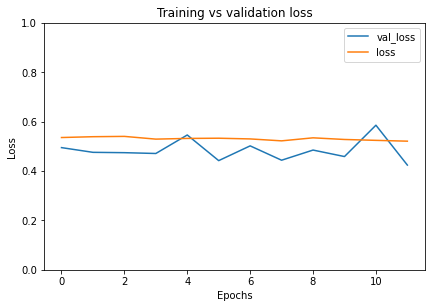

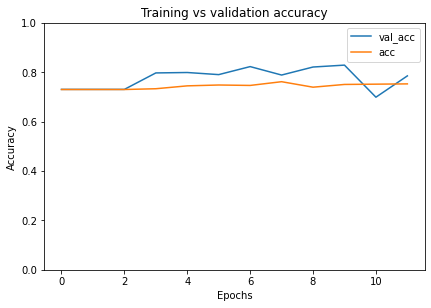

In [87]:
visualize_training_results(first_history)

              precision    recall  f1-score   support

         0.0       0.62      0.04      0.07       950
         1.0       0.74      0.99      0.84      2564

    accuracy                           0.73      3514
   macro avg       0.68      0.51      0.46      3514
weighted avg       0.71      0.73      0.64      3514



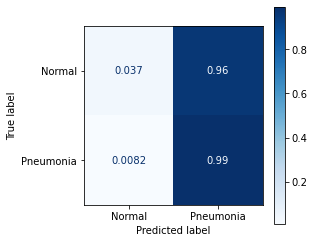

In [88]:
reports(first_model, train_img, train_labels)

              precision    recall  f1-score   support

         0.0       0.89      0.18      0.30       317
         1.0       0.77      0.99      0.86       854

    accuracy                           0.77      1171
   macro avg       0.83      0.59      0.58      1171
weighted avg       0.80      0.77      0.71      1171



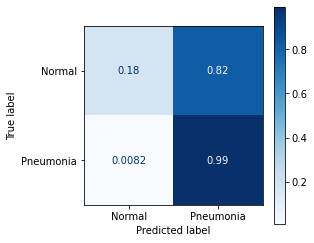

In [89]:
reports(first_model, test_img, test_labels)

> Our first model's train accuracy score is 73% and test accuracy score is 77%. The recall score is 99%. This is a little better than the dummy classifier. We will add layers to this model and tune parameters to see if any improvement can be made. 

## Second Model

The second model will have more hidden layers with smaller number of neurons added to the first model.

In [120]:
# building a nueral network 
second_model = models.Sequential()
second_model.add(layers.Dense(20, activation='relu')) 
second_model.add(layers.Dense(15, activation='relu'))
second_model.add(layers.Dense(7, activation='relu'))
second_model.add(layers.Dense(5, activation='relu'))
second_model.add(layers.Dense(1, activation='sigmoid'))

In [121]:
# compiling and fitting the model
second_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

second_history = second_model.fit(train_img, train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_labels),
                    callbacks=callback)

Epoch 1/50
110/110 [==============================] - 1s 8ms/step - loss: 0.7061 - accuracy: 0.7109 - val_loss: 0.5775 - val_accuracy: 0.7301
Epoch 2/50
110/110 [==============================] - 0s 5ms/step - loss: 0.5783 - accuracy: 0.7297 - val_loss: 0.5690 - val_accuracy: 0.7301
Epoch 3/50
110/110 [==============================] - 1s 5ms/step - loss: 0.5725 - accuracy: 0.7297 - val_loss: 0.5527 - val_accuracy: 0.7301
Epoch 4/50
110/110 [==============================] - 1s 5ms/step - loss: 0.5606 - accuracy: 0.7316 - val_loss: 0.5392 - val_accuracy: 0.7301
Epoch 5/50
110/110 [==============================] - 0s 4ms/step - loss: 0.5535 - accuracy: 0.7334 - val_loss: 0.5685 - val_accuracy: 0.7404
Epoch 6/50
110/110 [==============================] - 1s 5ms/step - loss: 0.5446 - accuracy: 0.7359 - val_loss: 0.5020 - val_accuracy: 0.7301
Epoch 7/50
110/110 [==============================] - 0s 5ms/step - loss: 0.5343 - accuracy: 0.7459 - val_loss: 0.5084 - val_accuracy: 0.7319
Epoch 

In [122]:
# evaluating the train accuracy score
results_train2 = second_model.evaluate(train_img, train_labels)
print("Train Loss: {:.5f}".format(results_train2[0]))
print("Train Accuracy: {:.2f}%".format(results_train2[1] * 100))

110/110 [==============================] - 0s 3ms/step - loss: 0.4567 - accuracy: 0.7886
Train Loss: 0.45670
Train Accuracy: 78.86%


In [123]:
# evaluating the test accuracy score
results_test2 = second_model.evaluate(test_img, test_labels)
print("Test Loss: {:.5f}".format(results_test2[0]))
print("Test Accuracy: {:.2f}%".format(results_test2[1] * 100))

37/37 [==============================] - 0s 2ms/step - loss: 0.3893 - accuracy: 0.8309
Test Loss: 0.38930
Test Accuracy: 83.09%


In [124]:
second_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 20)                2904020   
_________________________________________________________________
dense_25 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_26 (Dense)             (None, 7)                 112       
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 40        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 6         
Total params: 2,904,493
Trainable params: 2,904,493
Non-trainable params: 0
_________________________________________________________________


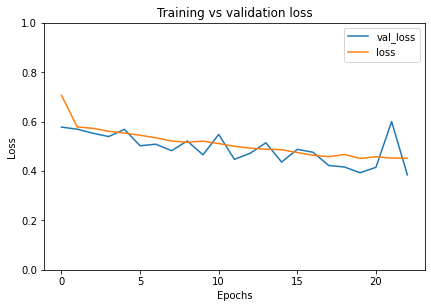

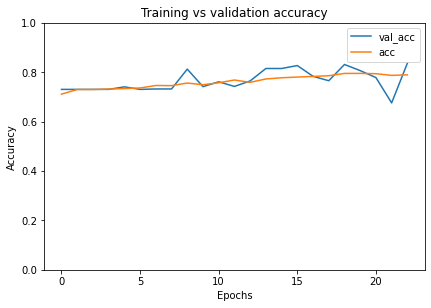

In [125]:
visualize_training_results(second_history)

              precision    recall  f1-score   support

         0.0       0.69      0.40      0.50       950
         1.0       0.81      0.93      0.87      2564

    accuracy                           0.79      3514
   macro avg       0.75      0.67      0.69      3514
weighted avg       0.77      0.79      0.77      3514



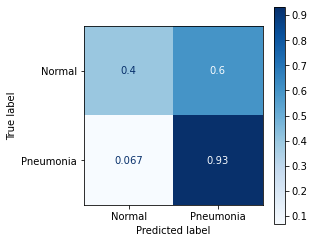

In [126]:
reports(second_model, train_img, train_labels)

              precision    recall  f1-score   support

         0.0       0.86      0.45      0.59       317
         1.0       0.83      0.97      0.89       854

    accuracy                           0.83      1171
   macro avg       0.84      0.71      0.74      1171
weighted avg       0.84      0.83      0.81      1171



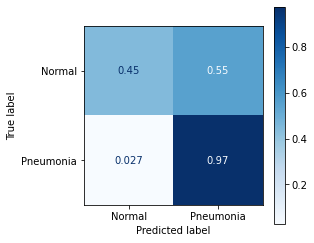

In [127]:
reports(second_model, test_img, test_labels)

> The second model has train accuracy score of 79% and test accuracy score of 83%. The recall score is 97%. Adding more layers improved the model's performance. Next, we will try building more complex models.

## Third Model with CNN

We will create the third model with Convolutional Neural Network(CNN).

In [144]:
# building a CNN model
third_model = models.Sequential()
third_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
third_model.add(layers.MaxPooling2D((2, 2)))

third_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
third_model.add(layers.MaxPooling2D((2, 2)))

third_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
third_model.add(layers.MaxPooling2D((2, 2)))

third_model.add(layers.Flatten())
third_model.add(layers.Dense(64, activation='relu'))
third_model.add(layers.Dense(1, activation='sigmoid'))

In [145]:
# compiling and fitting the model
third_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

third_history = third_model.fit(train_images,
                    train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images, val_labels),
                    callbacks=callback)

Epoch 1/30
110/110 [==============================] - 2s 17ms/step - loss: 0.5918 - accuracy: 0.7294 - val_loss: 0.5969 - val_accuracy: 0.7301
Epoch 2/30
110/110 [==============================] - 1s 13ms/step - loss: 0.5814 - accuracy: 0.7297 - val_loss: 0.5820 - val_accuracy: 0.7301
Epoch 3/30
110/110 [==============================] - 1s 13ms/step - loss: 0.5752 - accuracy: 0.7297 - val_loss: 0.5827 - val_accuracy: 0.7301
Epoch 4/30
110/110 [==============================] - 1s 13ms/step - loss: 0.5609 - accuracy: 0.7351 - val_loss: 0.5713 - val_accuracy: 0.7301
Epoch 5/30
110/110 [==============================] - 1s 13ms/step - loss: 0.5554 - accuracy: 0.7322 - val_loss: 0.5568 - val_accuracy: 0.7472
Epoch 6/30
110/110 [==============================] - 1s 13ms/step - loss: 0.5519 - accuracy: 0.7345 - val_loss: 0.5418 - val_accuracy: 0.7301
Epoch 7/30
110/110 [==============================] - 1s 13ms/step - loss: 0.5383 - accuracy: 0.7433 - val_loss: 0.5639 - val_accuracy: 0.7737

In [146]:
# evaluate the train accuracy score
results_train3 = third_model.evaluate(train_images, train_labels)
print("Train Loss: {:.5f}".format(results_train3[0]))
print("Train Accuracy: {:.2f}%".format(results_train3[1] * 100))

110/110 [==============================] - 1s 5ms/step - loss: 0.1682 - accuracy: 0.9388
Train Loss: 0.16817
Train Accuracy: 93.88%


In [147]:
# evaluate the test accuracy score
results_test3 = third_model.evaluate(test_images, test_labels)
print("Test Loss: {:.5f}".format(results_test3[0]))
print("Test Accuracy: {:.2f}%".format(results_test3[1] * 100))

37/37 [==============================] - 0s 5ms/step - loss: 0.2563 - accuracy: 0.8975
Test Loss: 0.25627
Test Accuracy: 89.75%


In [148]:
third_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 218, 218, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 106, 106, 32)      16416     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 51, 51, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 40000)           

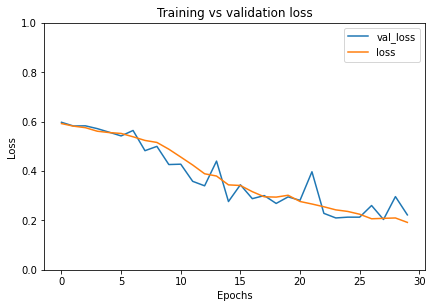

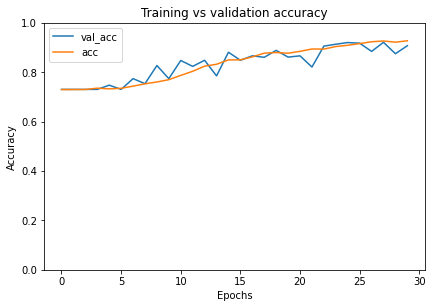

In [149]:
visualize_training_results(third_history)

              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88       950
         1.0       0.94      0.98      0.96      2564

    accuracy                           0.94      3514
   macro avg       0.94      0.90      0.92      3514
weighted avg       0.94      0.94      0.94      3514



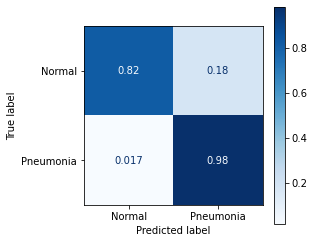

In [150]:
reports(third_model, train_images, train_labels)

              precision    recall  f1-score   support

         0.0       0.91      0.69      0.78       317
         1.0       0.89      0.98      0.93       854

    accuracy                           0.90      1171
   macro avg       0.90      0.83      0.86      1171
weighted avg       0.90      0.90      0.89      1171



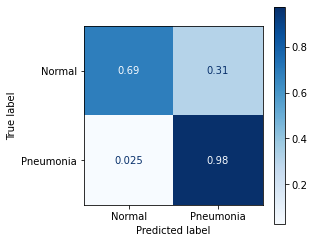

In [151]:
reports(third_model, test_images, test_labels)

>The third model has train accuracy score of 94% and test accuracy score of 90%. The recall score is 98%. This is a huge improvement.

## Fourth Model

We want to see if adding the class weight will change the result. We will use the third model with the class weight this time.

In [152]:
# building a CNN model
forth_model = models.Sequential()
forth_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
forth_model.add(layers.MaxPooling2D((2, 2)))

forth_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
forth_model.add(layers.MaxPooling2D((2, 2)))

forth_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
forth_model.add(layers.MaxPooling2D((2, 2)))

forth_model.add(layers.Flatten())
forth_model.add(layers.Dense(64, activation='relu'))
forth_model.add(layers.Dense(1, activation='sigmoid'))

In [153]:
# compiling and fitting the model
forth_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

class_weight = {0:2.0, 1:1.0}

forth_history = forth_model.fit(train_images,
                    train_labels,
                    epochs=30,
                    batch_size=32,
                    class_weight=class_weight,
                    validation_data=(val_images, val_labels),
                    callbacks=callback)

Epoch 1/30
110/110 [==============================] - 2s 17ms/step - loss: 0.8649 - accuracy: 0.6998 - val_loss: 0.6176 - val_accuracy: 0.7301
Epoch 2/30
110/110 [==============================] - 1s 13ms/step - loss: 0.8465 - accuracy: 0.6983 - val_loss: 0.6346 - val_accuracy: 0.7096
Epoch 3/30
110/110 [==============================] - 1s 13ms/step - loss: 0.8256 - accuracy: 0.7063 - val_loss: 0.5774 - val_accuracy: 0.7242
Epoch 4/30
110/110 [==============================] - 1s 13ms/step - loss: 0.7785 - accuracy: 0.7214 - val_loss: 0.5522 - val_accuracy: 0.7284
Epoch 5/30
110/110 [==============================] - 1s 13ms/step - loss: 0.7256 - accuracy: 0.7635 - val_loss: 0.4861 - val_accuracy: 0.8113
Epoch 6/30
110/110 [==============================] - 1s 13ms/step - loss: 0.6661 - accuracy: 0.7763 - val_loss: 0.4338 - val_accuracy: 0.7523
Epoch 7/30
110/110 [==============================] - 1s 13ms/step - loss: 0.5554 - accuracy: 0.8102 - val_loss: 0.7076 - val_accuracy: 0.6934

In [154]:
# evaluate the train accuracy score
results_train4 = forth_model.evaluate(train_images, train_labels)
print("Train Loss: {:.5f}".format(results_train4[0]))
print("Train Accuracy: {:.2f}%".format(results_train4[1] * 100))

110/110 [==============================] - 1s 5ms/step - loss: 0.0489 - accuracy: 0.9898
Train Loss: 0.04886
Train Accuracy: 98.98%


In [155]:
# evaluate the test accuracy score
results_test4 = forth_model.evaluate(test_images, test_labels)
print("Test Loss: {:.5f}".format(results_test4[0]))
print("Test Accuracy: {:.2f}%".format(results_test4[1] * 100))

37/37 [==============================] - 0s 5ms/step - loss: 0.2774 - accuracy: 0.9026
Test Loss: 0.27744
Test Accuracy: 90.26%


In [156]:
forth_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 218, 218, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 106, 106, 32)      16416     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 51, 51, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 40000)           

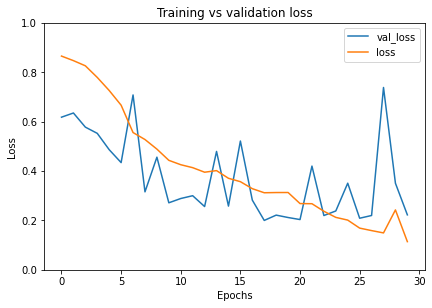

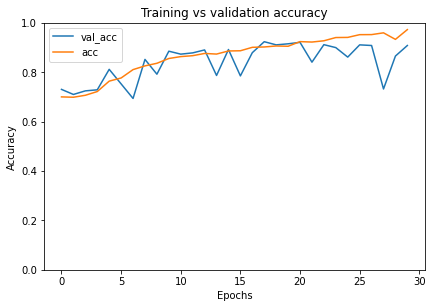

In [157]:
visualize_training_results(forth_history)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       950
         1.0       0.99      0.99      0.99      2564

    accuracy                           0.99      3514
   macro avg       0.99      0.99      0.99      3514
weighted avg       0.99      0.99      0.99      3514



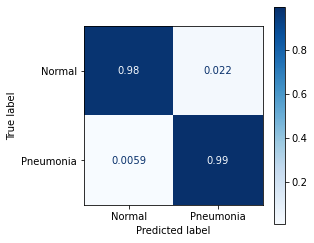

In [158]:
reports(forth_model, train_images, train_labels)

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       317
         1.0       0.93      0.93      0.93       854

    accuracy                           0.90      1171
   macro avg       0.88      0.88      0.88      1171
weighted avg       0.90      0.90      0.90      1171



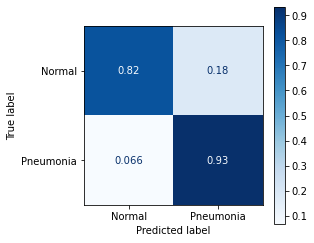

In [159]:
reports(forth_model, test_images, test_labels)

>The forth model has train accuracy score of 99% and test accuracy score of 90%. The recall score is 93%. Adding class weight did not seem to help the model performance. 

##  Conclusion
The third model using CNN proved to perform the best with the accuracy score of 90% and the recall score of 98%.